In [22]:
import TensorNetwork
import Entangler
from qiskit import QuantumRegister, ClassicalRegister, execute, Aer, QuantumCircuit
import numpy as np
import hamiltonians
import TNOptimize
from scipy.optimize import minimize
from skopt import gp_minimize
import matplotlib.pyplot as plt

In [2]:
n_qubits = 4
q, c = QuantumRegister(n_qubits), ClassicalRegister(n_qubits)
ent = Entangler.IsingEntangler()
tn_1 = TensorNetwork.Checkerboard(q, c, ent, depth=3)
tn_2 = TensorNetwork.Checkerboard(q, c, ent, depth=4)

params_1 = np.random.rand(tn_1.n_params)
params_2 = np.random.rand(tn_2.n_params)

### Prepare data

In [3]:
h_left = np.linspace(0.1, 0.3, num=5)
h_right = np.linspace(2, 2.5, num=5)


sols_left = []
sols_right = []

J = 1
for h in h_left:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    sols_left.append([res.x, h, -1])
    print(h)

print('halfway there')
    
for h in h_right:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    sols_left.append([res.x, h, 1])
    print(h)
    
    
print('success')

0.1
0.15
0.2
0.25
0.3
halfway there
2.0
2.125
2.25
2.375
2.5
success


In [4]:
h_test = np.linspace(0.5, 1.5, num=5)

test_data = []

for h in h_test:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    test_data.append([res.x, h, np.nan])
    print(h)

0.5
0.75
1.0
1.25
1.5


In [5]:
train_data = sols_left + sols_right
full_data = train_data + test_data

In [11]:
from qiskit import QuantumCircuit, execute, Aer
import numpy as np

def prediction(sol_params, classifier_params, tn_1, tn_2, shots=1024):
    circ_1 = tn_1.construct_circuit(sol_params)
    circ_2 = tn_2.construct_circuit(classifier_params)
    
    # Create a new quantum circuit for measurement that matches the size of circ_1
    measure_circ = QuantumCircuit(circ_1.num_qubits, circ_1.num_clbits)
    for i in range(circ_1.num_qubits):  # Assuming n_qubits matches circ_1.num_qubits
        measure_circ.measure(i, i)
    
    # Compose circ_1 with circ_2, then add the measurement circuit
    total_circ = circ_1.compose(circ_2).compose(measure_circ)
    
    sv_backend = Aer.get_backend('statevector_simulator')
    job = execute(total_circ, sv_backend)
    result = job.result()
    
    # Access the statevector as a numpy array
    statevec = result.get_statevector().data  # Use .data to get the numpy array
    
    # Compute the label using the first and last element of the statevector
    label = (-1 * abs(statevec[0])**2 + abs(statevec[-1])**2)
    
    return label


In [12]:
# sol_params = full_data[1][0]
# classifier_params = np.random.rand(tn_2.n_params)

# circ_1 = tn_1.construct_circuit(sol_params)
# circ_2 = tn_2.construct_circuit(classifier_params)

# total_circ = circ_1 + circ_2 + measure_circ

# job = execute(total_circ, sv_backend)
# result = job.result()

# statevec = result.get_statevector(total_circ)


In [13]:
train_data[5][0]

array([ 0.26585281, -1.6580126 , -1.04962912, -1.60588993,  0.44523952,
        1.5710937 ,  1.56974546, -1.56817221, -1.69756401, -1.24666556,
        0.02542482,  1.10900945, -5.95654508, -0.98280643, -2.92072824,
        3.04084252,  1.5606949 , -5.95706429, -2.65702414, -4.57723429,
        3.51002541,  3.51268113, -7.85158181, -3.12257968, -3.15086332,
        1.56331214,  1.56756901, -6.27546928, -3.14704525, -3.21462282])

In [14]:
prediction(train_data[0][0], np.random.rand(tn_2.n_params), tn_1, tn_2)

0.0

In [15]:
def loss_fun(train_data, classifier_params, tn_1, tn_2):
    loss = 0
    for data in train_data:
        label_pred = prediction(data[0], classifier_params, tn_1, tn_2)
        loss += abs(data[2] - label_pred)
    return loss

In [16]:
loss_fun(train_data, np.random.rand(tn_2.n_params), tn_1, tn_2)

7.0

In [17]:
def f(x):
    return loss_fun(train_data, x, tn_1, tn_2)

In [18]:
x = np.random.rand(tn_2.n_params)
f(x)

10.0

In [19]:
res_training = minimize(f, np.random.rand(tn_2.n_params), options={"maxiter":50})
res_training.message

'Desired error not necessarily achieved due to precision loss.'

In [15]:
# res = gp_minimize(f, [(0, 2 * np.pi)] * tn_2.n_params, n_calls=100, verbose=False)

In [16]:
# plt.scatter(np.arange(100), res.func_vals)

In [20]:
for d in full_data:
    prd = prediction(d[0], res_training.x, tn_1, tn_2)
    print('h: {0:0.2f}, Actual: {1:0.2f}, Predicted: {2:0.2f}'.format(d[1], d[2], prd))

h: 0.10, Actual: -1.00, Predicted: 0.00
h: 0.15, Actual: -1.00, Predicted: 0.00
h: 0.20, Actual: -1.00, Predicted: 1.00
h: 0.25, Actual: -1.00, Predicted: 0.00
h: 0.30, Actual: -1.00, Predicted: 0.00
h: 2.00, Actual: 1.00, Predicted: 1.00
h: 2.12, Actual: 1.00, Predicted: 1.00
h: 2.25, Actual: 1.00, Predicted: 0.00
h: 2.38, Actual: 1.00, Predicted: 1.00
h: 2.50, Actual: 1.00, Predicted: 1.00
h: 0.50, Actual: nan, Predicted: 0.00
h: 0.75, Actual: nan, Predicted: 0.00
h: 1.00, Actual: nan, Predicted: 1.00
h: 1.25, Actual: nan, Predicted: 1.00
h: 1.50, Actual: nan, Predicted: 1.00


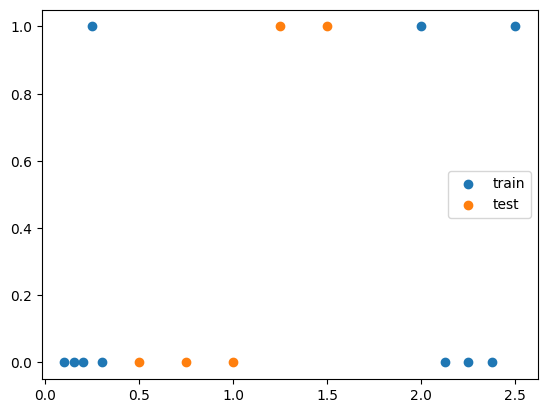

In [21]:
h_data = [d[1] for d in train_data]
predicted = [prediction(d[0], res_training.x, tn_1, tn_2) for d in train_data]

h_2 = [d[1] for d in test_data]
prd_test = [prediction(d[0], res_training.x, tn_1, tn_2) for d in test_data]

plt.scatter(h_data, predicted, label='train')
plt.scatter(h_2, prd_test, label='test')
plt.legend()